# Setup Environment (Colab)

In [ ]:
# Install required libraries
!pip install opencv-python-headless kaggle


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Download FER2013 Dataset (Kaggle)

In [5]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rigel07","key":"d9b570c3043f6a5d5f3daf729c40dcd0"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip


# View Sample Images

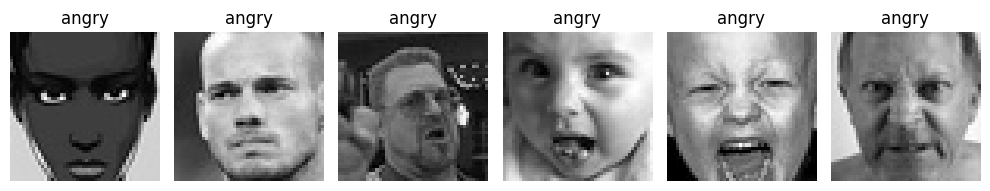

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import random

data_dir = "train"   # or "test"
emotion = random.choice(os.listdir(data_dir))
emotion_path = os.path.join(data_dir, emotion)

images = random.sample(os.listdir(emotion_path), 6)

plt.figure(figsize=(10,4))

for i, img_name in enumerate(images):
    img_path = os.path.join(emotion_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(1,6,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing & Augmentation

In [8]:
IMG_SIZE = 48
BATCH_SIZE = 64


In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


In [22]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model Architecture

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    Flatten, BatchNormalization
)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.30))

# Block 3
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.35))

# Dense Head
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))


In [24]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

# Train the Model

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, min_lr=1e-6),
    ModelCheckpoint(
        "best_emotion_model.h5",
        monitor='val_accuracy',
        save_best_only=True
    )
]


In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=80,
    callbacks=callbacks
)



# Accuracy & Loss Graphs

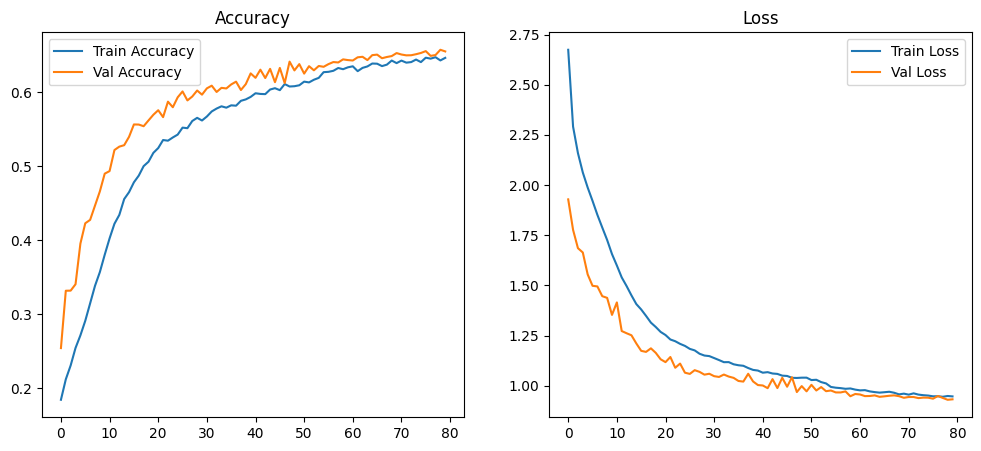

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


# Save the Model::

In [19]:
model.save("emotion_model.keras")

# Real-Time Emotion Detection (Local System)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("best_emotion_model.h5")

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48,48))
        roi = roi / 255.0
        roi = roi.reshape(1,48,48,1)

        prediction = model.predict(roi)
        label = emotion_labels[np.argmax(prediction)]

        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(frame,label,(x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,255,0),2)

    cv2.imshow("Emotion Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
